# Data Analysis Task

## Basic terminology:
-- Fraud - the use of a stolen credit card to purchase online
-- A chargeback (CHB) - a charge that is returned to a payment card after a customer
successfully disputes an item on their account transactions report
COMPANY business model:
We collect a small fraction (fee) of the amount of all approved orders and give a chargeback guarantee for the full order amount if an order we approve comes back as a chargeback.

## COMPANY decision-engine:
All orders are given a score by the model (“classification score”)
For each merchant, we define a threshold between 0 to 1 for each model.
-- When the classification score is above the threshold, the model’s action will be “approve” and order will be auto-approved
-- When the classification score is below the threshold, the model’s action will be “decline” and the order will be auto-declined
The following dataset consists of 40,825 orders, classifications for these orders by a single model, and a few of the data points we collect for each order.




## Data Dictionary 
- order_id: a unique identifier for an order
- order_date: the date in which the order was submitted to Riskified
- order_status : the actual status of an order (in this dataset we included only approvals
and chargebacks)
- price: order total amount
- digital_product: whether the product is digital or tangible
- customer_account_age: the interval between the date the account was created and the
order was placed
- order_source: the type of device used to place the order (web/mobile device
app/phone/etc.)
- billing_zip: the zip code filled in the billing details
- shipping_name_length: shipping name number of characters
- classification_score: the score given by the model

## Task 
1. Rely exclusively on model scores using COMPANY decision-engine, and set a decline threshold that will provide a 90% approval rate
2. Plot the model scores distribution
3. Assuming we aim at a proportion of 50% between the CHB cost and the total revenue (sum amount of CHBs divided by the total revenue), what would have to be the fee based Riskified’s business model?
4. In the dataset, there’s a column indicating whether the purchased goods are digital or tangible. What can you say about the risk level of each segment?
5. Free exploration - Provide 2-3 interesting breakdowns or insights.



In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# read orig csv into pandas dataframe and make working copy
original = pd.read_csv('fraud_dataset.csv')
df = original.copy()
df.head()

,order_id,order_date,order_status,price,digital_product,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score
0,906967102,2019-06-01,approved,213.88,False,0,web,33062,13,0.999219
1,906987974,2019-06-01,approved,50.00,True,0,mobile_app,48317,0,0.995886
2,906994260,2019-06-01,approved,100.00,True,328,web,92124,0,0.966901
3,906997653,2019-06-01,approved,25.00,True,1371,web,95448,0,0.999854
4,907408483,2019-06-01,approved,2035.76,False,139,web,61107,17,0.999965


## EDA 

In [3]:
# verify dataset number of rows, col, check for nulls, confirm datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40825 entries, 0 to 40824
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              40825 non-null  int64  
 1   order_date            40825 non-null  object 
 2   order_status          40825 non-null  object 
 3   price                 40825 non-null  float64
 4   digital_product       40825 non-null  bool   
 5   customer_account_age  40825 non-null  int64  
 6   order_source          40825 non-null  object 
 7   billing_zip           40825 non-null  object 
 8   shipping_name_length  40825 non-null  int64  
 9   classification_score  40825 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(4)
memory usage: 2.8+ MB


notes
- .info confirms size of dataset size (40,825)
- no nulls
- data types match expected content
- order_date not datetime
- shipping_name_length does not look relevent for this analysis 

###### EDA: Object Features

In [4]:
# count number of unique items in selected objects and print unique items if less than 20 
object_list = ['order_status', 'order_source', 'billing_zip']
for item in object_list:
    if df[item].nunique() < 20:
        print(item, df[item].nunique(),df[item].unique())
    else:
        print(item, df[item].nunique())

order_status 2 ['approved' 'chargeback']
order_source 2 ['web' 'mobile_app']
billing_zip 10328


- order status has only 2 unqique values: approved and chargeback
- order source has only 2 unique values: web and mobile 

In [5]:
# return count and % of unique values in selected objects (order_status and order_source)
for item in object_list:
    if df[item].nunique() < 20:
        print(item, df[item].value_counts().to_frame())
        print(item, df[item].value_counts(normalize=True).to_frame())

order_status             order_status
approved           40465
chargeback           360
order_status             order_status
approved        0.991182
chargeback      0.008818
order_source             order_source
web                40151
mobile_app           674
order_source             order_source
web             0.983491
mobile_app      0.016509


**notes on selected object fields**
- billing zips over 10K unique values - not likely to use without further analysis 
- order status and order source each have 2 unique selections 
- 99% (40,151) of all order are approved (1% chargebacks)
- 98% of all orders: web orders (2% mobile)

In [6]:
# additional eda around approvals/chargebacks as a proportion of total 
# count of total orders using rows

total_orders = df.shape[0]
print ('total orders: {:,d}'.format(total_orders))

# count of orders approved /chargebacks
approval_count = df['order_status'].value_counts()['approved']
chargeback_count = df['order_status'].value_counts()['chargeback']

#approved_percent = df['order_status'].value_counts(normalize=True)['approved']
#chargeback_percent = df['order_status'].value_counts(normalize=True)['chargeback']
approved_percent = approval_count/total_orders *100
chargeback_percent = chargeback_count/total_orders *100

# print results
print("approval count: {:,d} ({:.2f}%)".format(approval_count, approved_percent))
print("chargeback count: {:,d} ({:.2f}%)".format(chargeback_count, chargeback_percent))


total orders: 40,825
approval count: 40,465 (99.12%)
chargeback count: 360 (0.88%)


###### EDA on Integer features 

In [7]:
# Calculate the minimum, maximum, and mean customer account age in days and years
min_customer_age = df.customer_account_age.min()
max_customer_age = df.customer_account_age.max()
mean_customer_age = df.customer_account_age.mean()

# Print the results in both days and years
print('Minimum customer account age: {:.0f} days ({:.2f} years)'.format(min_customer_age, min_customer_age/365))
print('Maximum customer account age: {:.0f} days ({:.2f} years)'.format(max_customer_age, max_customer_age/365))
print('Mean customer account age: {:.2f} days ({:.2f} years)'.format(mean_customer_age, mean_customer_age/365))


Minimum customer account age: -3 days (-0.01 years)
Maximum customer account age: 6298 days (17.25 years)
Mean customer account age: 736.80 days (2.02 years)


In [8]:
start_order_date = df.order_date.min()
end_order_date = df.order_date.max()
print('start order date: ', start_order_date)
print('end order date: ', end_order_date)

start order date:  2019-06-01
end order date:  2019-07-01


In [9]:
min_price = df.price.min()
max_price = df.price.max()
mean_price = df.price.mean()
print('min_price: ${:.0f}'.format(min_price))
print('max_price: ${:,.0f}'.format(max_price))
print('mean_price: ${:.0f}'.format(mean_price))

min_price: $0
max_price: $11,033
mean_price: $396


**Notes on integer fields**
- customer acount age 
    - check negative min age - perhaps it is possible to order before 
     creating account
    - metric assumued to be days
    - avg customer acount age: 736 days / 2.02 years
- date ordered
    - can be transformed to datetime
    - one month of data
- price 
    - avg order $396

**Price EDA**

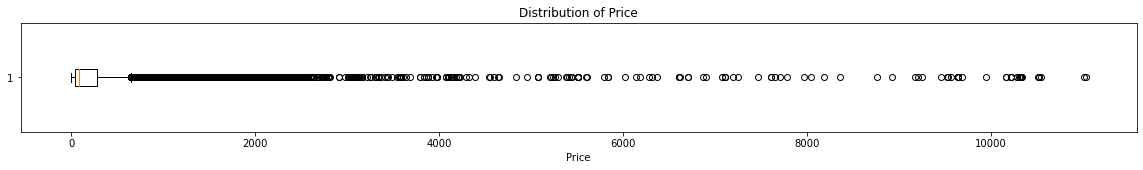

,price
count,40825.0
mean,396.0
std,772.0
min,0.0
25%,35.0
50%,82.0
75%,280.0
max,11033.0


In [10]:
# create price boxplot 
fig, ax = plt.subplots(figsize=(20, 2))
ax.boxplot(df['price'], vert=False)

# label
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.show()

#describe (summary stats on price)
df.price.describe().round().to_frame()


In [11]:
print(df['price'].median())

82.44


**Price Distribution (Box Plot)**
* box represents the interquartile range (IQR) - middle 50% of the data
* lower edge of box - 25th percentile (Q1)
* upper edge of box - 75th percentile (Q3)
* horizontal line in box - median (50th percentile) 
* whiskers - min and max values that are within 1.5 times the IQR from box edge 
* outliers - data points outside the range 
* 75% of all items in dataset under $280 price

* median price $82


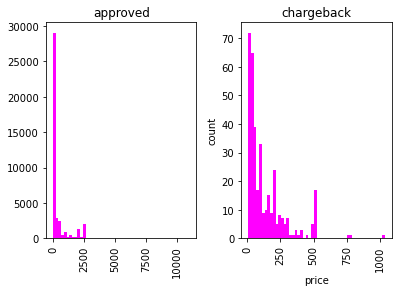

In [12]:
# price distribution by order status 
df.hist(column='price', by = 'order_status', color= 'magenta',bins=50)
plt.ylabel('count')
plt.xlabel('price')
plt.show()

In [13]:
# orders with a price under $1000
under_1000 = len(df[df['price'] < 1000])/ total_orders *100

print('{:.2f}% of orders are priced under $1000'.format(under_1000))

86.56% of orders are priced under $1000


In [16]:
# create price pivot table calculate summary statistics of price for each order_status
price_pivot_df = pd.pivot_table(df, index='order_status', values='price', aggfunc=['describe', 'sum'])
sum_price_pivot_df = pd.pivot_table(df, index='order_status', values='price', aggfunc='sum')
sum_price_pivot_df = price_pivot_df.applymap('${:,.2f}'.format)
sum_price_pivot_df

describe                                                    \
                  25%     50%      75%       count         max     mean   
order_status                                                              
approved       $35.91  $82.44  $284.70  $40,465.00  $11,033.31  $398.44   
chargeback     $34.11  $80.95  $200.00     $360.00   $1,033.73  $135.10   

                                         sum  
                min      std           price  
order_status                                  
approved      $0.00  $774.55  $16,122,719.73  
chargeback    $9.80  $147.64      $48,637.12

**Price Distribution**

*  86% orders under $1000
*  no normal distubtion on price (can drop outliers for additional analysis)

*Chargebacks*
* chargeback price range $ 9.80 - 1,033

* sum of all chargeback: $48,637.12

* 75% of all chargebacks price under $200 

*Approved* 
* approved price range $ 0 - 11,033

* 75% of approved orders price under $285 

* sum of all approved: $16,122,719.73
    


**Classification Score EDA** 

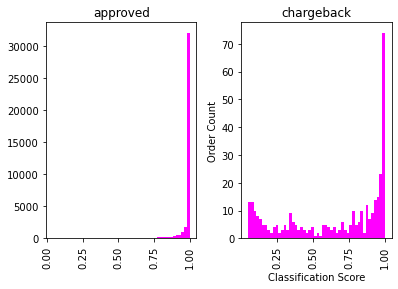

In [18]:
# distribution of order_status (approved/chargeback) by score (0-1)
df.hist(column='classification_score', by='order_status', bins=50, color='magenta')
plt.xlabel('Classification Score')
plt.ylabel('Order Count')
plt.show()

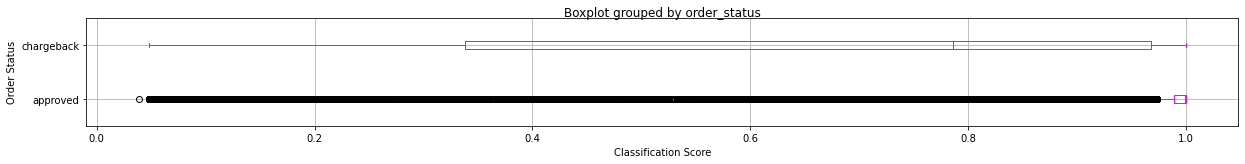

classification_score                                         \
                              25%       50%       75%    count       max   
order_status                                                               
approved                 0.989386  0.999204  0.999897  40465.0  1.000000   
chargeback               0.337844  0.785808  0.968291    360.0  0.999997   

                                            
                  mean       min       std  
order_status                                
approved      0.945900  0.038408  0.163566  
chargeback    0.649584  0.048232  0.340546

In [19]:
# score box plot by order staus 
fig, ax = plt.subplots(figsize=(20, 2))
df.boxplot(column=['classification_score'], by='order_status', vert=False, color='magenta', ax=ax)
plt.xlabel('Classification Score')
plt.ylabel('Order Status')
plt.title('')
plt.show()

# pivot table to calculate summary stats on fraud_score on order_status
score_pivot_df = df.pivot_table(values=['classification_score'], index='order_status', aggfunc='describe')
score_pivot_df


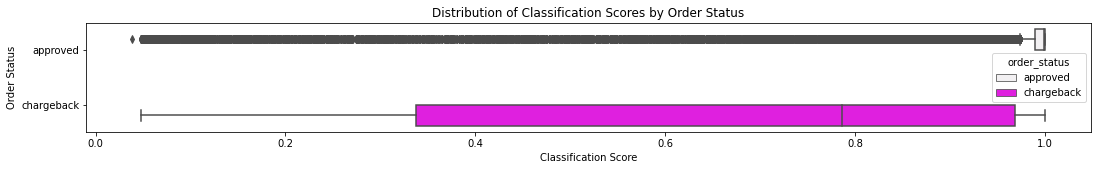

0

In [49]:
# create classification score boxplot by order status
fig, ax = plt.subplots(figsize=(18, 2))
sns.boxplot(data=df, x='classification_score', y='order_status', hue='order_status', color='magenta', orient='h', ax=ax)
ax.set_xlabel('Classification Score')
ax.set_ylabel('Order Status')
plt.title('Distribution of Classification Scores by Order Status')
plt.show()


** Summary Stats on Classification Score ** 

*Approved*
- Approved scores range from .038 - 1
- 50% approved above  .999
- 75% approved above .989
- low scores that are approved are outliers

*Chargebacks*
- Chargeback scores range from .048 - .99
- 50% chargebacks above .785
- 25% chargebacks above .968


**Notes**
- chargebacks: >100 orders with approval scores @/near with high score on the model(1), but ended up being a fraud resulting in chargeback 
- can investigage chargebacks over thershold and see if common thread
- Scale of chargebacks to total count of orders is too small to see chargenback on single histogram 

In [21]:
# subframes by order_status
approved_orders = df[df['order_status']== 'approved']
chargeback_orders = df[df['order_status']== 'chargeback']

# approved orders subframe
approved_orders.sort_values('classification_score')

# chargeback orders subframe 
chargeback_orders.sort_values('classification_score')

,order_id,order_date,order_status,price,digital_product,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score
21246,941402457,2019-06-25,chargeback,130.95,True,1275,web,94587,0,0.048232
25857,950499862,2019-07-01,chargeback,50.00,True,0,mobile_app,14845,0,0.048683
32157,918120660,2019-06-08,chargeback,71.90,True,20,web,37075,0,0.049227
3987,917848677,2019-06-08,chargeback,35.95,True,0,mobile_app,37075,0,0.050901
18906,929597580,2019-06-16,chargeback,40.95,True,1569,web,92241,0,0.053618
...,...,...,...,...,...,...,...,...,...,...
16662,944971017,2019-06-28,chargeback,30.95,True,1135,web,92071,0,0.999646
35265,944521519,2019-06-27,chargeback,114.82,False,447,web,93065,8,0.999648
9326,937489254,2019-06-22,chargeback,15.95,True,0,web,02118,0,0.999649
38145,939162674,2019-06-23,chargeback,25.00,True,22,web,95208,0,0.999693


#### Digital Product EDA

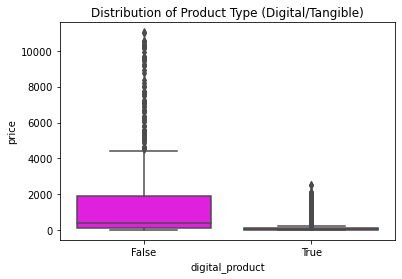

describe                                        \
                                price                                         
                                  25%     50%        75%    count       max   
order_status digital_product                                                  
approved     False             107.44  408.94  1893.8875  13498.0  11033.31   
             True               26.00   50.00   105.9500  26967.0   2497.74   
chargeback   False             202.75  308.69   508.9400     40.0   1033.73   
             True               30.95   55.95   155.9500    320.0    505.95   

                                                              
                                                              
                                    mean    min          std  
order_status digital_product                                  
approved     False            915.530484   0.00  1105.069831  
             True             139.610979   0.00   296.918535  
chargeback   False            362.710500  26.99   216.827451  
             True             106.652188   9.80   107.119672

In [22]:
# create a boxplot of price by digital_product
sns.boxplot(data=df, x='digital_product', y='price', color='magenta')
plt.title('Distribution of Product Type (Digital/Tangible)')
plt.show()

#pivot 
digital_pivot_df = df.pivot_table(values=['price'], index=['order_status', 'digital_product'], aggfunc=['describe'])
digital_pivot_df

#digital_pivot_df = pd.pivot_table(df, index='order_status', values ='price', columns='digital_product', aggfunc = 'sum', margins = True, margins_name='Total')

**Digital Product**

*Digital Product*

* count of 320 chargebacks
* price range of digital product chargebacks $ 9.80-505

* 25% digital products are more than $ 155

*Tangible Product* 
* count of 40 chargebacks 
* price range of tangibel product chargebacks $ 26.99 - 1033

* 25% tangible products over  $508


## 1. Rely exclusively on model scores using Company decision-engine, and set a decline threshold that will provide a 90% approval rate

In [23]:
# 1. new df that sorts model scores desc
df_sorted = df.sort_values('classification_score', ascending = False)
df_sorted

# 2. set threshold 
threshold = 0.90

# 3. calculate count of orders that will be approved using threshold 
num_orders_approved_90 = int(total_orders * threshold)
print('In df sorted by score desc,', num_orders_approved_90,'orders approved, '\
      'of', total_orders, 'total orders, using',threshold , 'approval threshold.')

# 4. locate 'threshold score' using location of threshold count of sorted_df 
threshold_score = df_sorted.iloc[num_orders_approved_90]['classification_score']
print('\nOrders with scores > threshhold score:', threshold_score, 'will be approved.')

# 5. create new col (new order_status) -populate based approvals based on on >/< threshold score 
df_sorted["new_order_status"] = \
    np.where(df_sorted["classification_score"]>= threshold_score, "approved", "chargeback" )

print('\nDataframe with 90% Threshold')
df_sorted.head()


In df sorted by score desc, 36742 orders approved, of 40825 total orders, using 0.9 approval threshold.

Orders with scores > threshhold score: 0.860766183838456 will be approved.

Dataframe with 90% Threshold


,order_id,order_date,order_status,price,digital_product,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score,new_order_status
23097,945827823,2019-06-28,approved,16.44,False,759,web,98109,9,1.000000,approved
1094,932303597,2019-06-18,approved,150.00,True,894,web,52761,0,0.999999,approved
27364,916501223,2019-06-07,approved,105.94,False,5160,web,60047,10,0.999999,approved
22754,916516038,2019-06-07,approved,100.00,True,1267,web,46516,0,0.999999,approved
22622,925554558,2019-06-13,approved,225.00,True,889,web,52761,0,0.999999,approved


In [24]:
# confirm new_order_status contains 90% approvals
print(df_sorted['new_order_status'].value_counts(normalize=True).to_frame())

            new_order_status
approved            0.900012
chargeback          0.099988


Process 
1. new dataframe sorted by score in descending order
2. count orders, identify order number representing approval threshold
3. extract the score from the last row of sorted_df represending approval threshold 
4. create new column and populate setting 'approvals' > threshold score and 'chargebacks' < threshold score
5. check work by checking percentage of approvals in new status col 

## 2. Plot the model scores distribution

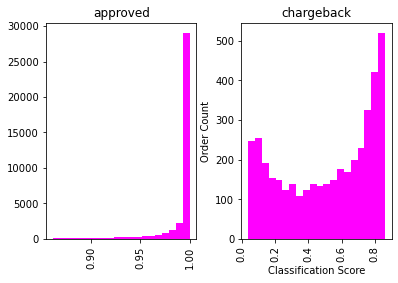

In [25]:
# new distribution of order status by score using pandas
df_sorted.hist(column='classification_score', by='new_order_status', bins=20, color='magenta')
plt.xlabel('Classification Score')
plt.ylabel('Order Count')
plt.show()

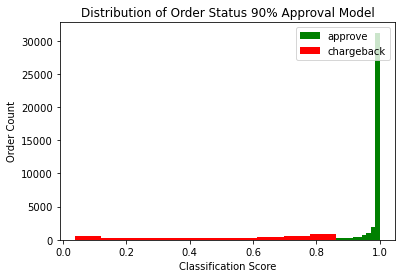

In [26]:
# dist of new model with matplotlib
plt.hist(df_sorted[df_sorted['new_order_status'] == 'approved']['classification_score'], color='green', label='approve')
plt.hist(df_sorted[df_sorted['new_order_status'] == 'chargeback']['classification_score'], color='red', label='chargeback')

# labels and legend
plt.xlabel('Classification Score')
plt.ylabel('Order Count')
plt.legend(loc='upper right')
plt.title('Distribution of Order Status 90% Approval Model')
plt.show()

distribution 
* sanity check to confirm adjusted dataframe  

## 3. Assuming we aim at a proportion of 50% between the CHB cost and the total revenue (sum amount of CHBs divided by the total revenue), what would have to be the fee based Company business model?

In [27]:
# check data to see if chargeback are booked as neg revenue
chargeback_neg = df[df['price']< 0].value_counts()
chargeback_neg

Series([], dtype: int64)

sanity check 
- price data all > 0
- original eda price min = 0 

##### Scenario: Calculate Company Fee 
    * assumption goal fee: cover chargeback cost + 50%

In [28]:
# total revenue (incl chargebacks)
total_rev = df['price'].sum()
print('total revenue: ${:,.0f}'.format(total_rev))

# calcualate sum approved 
sum_approved = df[df["order_status"] == "approved"]["price"].sum()
print('sum value of approved orders ${:,.0f}'.format(sum_approved))

# calculate sum chargebacks
sum_chargeback = df[df["order_status"] == "chargeback"]["price"].sum()
print('sum value of chargebacks: ${:,.0f}'.format(sum_chargeback))

# chargeback as a percent of total revenues 
percent_chargeback_cost_actual = sum_chargeback/total_rev 
print ('\nchargeback as a percent of total revenue: {:.1%}'.format(percent_chargeback_cost_actual))

#"proportion of 50% between the CHB cost and the total revenue"
# given the CHB cost .3% of revenue above line was interpreted to 
# calculate goal  for fee: fee to cover chargeback + 50% of chargeback - adjustments can be made as more clarification is provided
fee_amount_50_over_chargeback = 1.5 * sum_chargeback
print ('\nfee amount goal (1.5x sum of chargeback): ${:,.0f}'.format(fee_amount_50_over_chargeback))

#fee goal # should rev be total appoved 
fee_threshild_50_over_chargeback = fee_amount_50_over_chargeback / total_rev 
print ('\nfee as percent of revenue: {:.1%}'.format(fee_threshild_50_over_chargeback))

total revenue: $16,171,357
sum value of approved orders $16,122,720
sum value of chargebacks: $48,637

chargeback as a percent of total revenue: 0.3%

fee amount goal (1.5x sum of chargeback): $72,956

fee as percent of revenue: 0.5%


**Notes**
- .45% fee on all transactions is needed to cover all chargebacks + 50% of chargeback fees 
- seems low should investigate industry standard
- given the .3% chargeback costs, this has been interpreted to mean recover all chargeback cost + 50%
- adjustments can be made as more information becomes available

**REQUESTED Clarifiction on original question**
- Orig Q: "a proportion of 50% between the CHB cost and the total revenue" 
- Orig definition COMPANY Business Model: "We collect a small fraction (fee) of the amount of all approved orders and give a chargeback guarantee for the full order amount if an order we approve comes back as a chargeback." 
- Revenue defined as :"sum amount of CHBs divided by the total revenue" interpreted as revenue of customer
 


##### Scenario: Calculate COMPANY Fee 
    * assumption chargeback cost: total revenue = 50%
    * COMPANY fee amount assumed using assumed 1.5% fee threshold
    * COMPANY fee calculated using assumed goal threshold amount of $100,000  


In [31]:
# calculate total revenue by adding all enterants in price col
total_revenue = df.price.sum()
print("total revenue: ${:,.0f}".format(total_revenue))

# calculate CHB as 50% of all revenue
CHB_to_revenue_50 = total_revenue *.50
print("CHB: Total Revenue (50% ratio): ${:,.0f}".format(CHB_to_revenue_50))

# set fee (based on CC fees) can be changed
Company_fee_threshold = .015
print("\nAssumed Company_fee_threshold: {:.1%}".format(Company_fee_threshold))

# calculate amount riskified would collect on accepted orders based on fee threshold
Company_fee_collected =  CHB_to_revenue_50 * Company_fee_threshold
print("Company_fee_collected using assumed fee threshold: ${:,.0f}".format(Company_fee_collected)) 

# set goal income (arbitrary ) can be changed
Company_goal_income = 100000
print("\nCompany_goal_income: ${:,.0f}".format(Company_goal_income) )

Company_goal_fee = Company_goal_income/CHB_to_revenue_50
print("Company_goal_fee: {:.1%}".format(Company_goal_fee))

total revenue: $16,171,357
CHB: Total Revenue (50% ratio): $8,085,678

Assumed Company_fee_threshold: 1.5%
Company_fee_collected using assumed fee threshold: $121,285

Company_goal_income: $100,000
Company_goal_fee: 1.2%


## 4. In the dataset, there’s a column indicating whether the purchased goods are digital or tangible. What can you say about the risk level of each segment?

##### Percent of Orders:  
    * Digital Product(True) & Tangible Product(False)

In [32]:
print(df.digital_product.value_counts(normalize=True).to_frame())

       digital_product
True          0.668389
False         0.331611


In [33]:
# order_status of digital products
df[df['digital_product']==True]['order_status'].value_counts(normalize=True).to_frame()

,order_status
approved,0.988273
chargeback,0.011727


In [34]:
# %approved / chargebacks of tangible products
df[df['digital_product']==False]['order_status'].value_counts(normalize=True).to_frame()

,order_status
approved,0.997045
chargeback,0.002955


##### Sum of Revenue:  
    * Digital Product(True) & Tangible Product(False) by Status(approved/chargeback)

In [35]:
# create chart to sum price of digital/tangible products sorted by approval status
digital_pivot_df = pd.pivot_table(df, index='order_status', values ='price', columns='digital_product', aggfunc = 'sum', margins = True, margins_name='Total')
digital_pivot_df = digital_pivot_df.applymap('${:,.0f}'.format)
digital_pivot_df

digital_product,False,True,Total
order_status,,,
approved,"$12,357,830","$3,764,889","$16,122,720"
chargeback,"$14,508","$34,129","$48,637"
Total,"$12,372,339","$3,799,018","$16,171,357"


**Notes**
- digital products: 66% of count of orders
- digital products: 24% of order totals by price 
- digital product riskier by count of orders: 
    - greater number of  chargbacks (1% digital product : .3% of tangible products)
- tangible product result >2x $$ lost to chargebacks

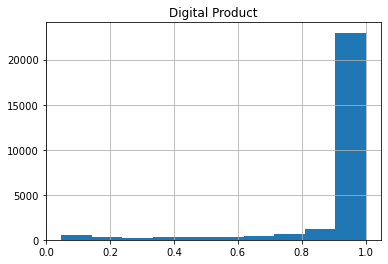

In [36]:
# plot digital_product & classifcation_score 
df[df['digital_product']==True]['classification_score'].hist()
plt.title('Digital Product')
plt.show()

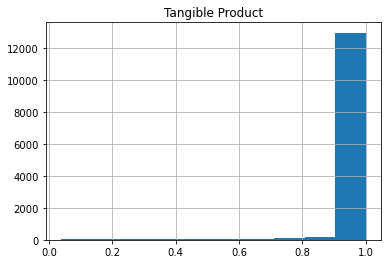

In [37]:
#plot digital_product & classifcation_score 
df[df['digital_product']==False]['classification_score'].hist()
plt.title('Tangible Product')
plt.show()

## 5. Free exploration - Provide 2-3 interesting breakdowns or insights.

#### Order Source Analysis

In [38]:
# group order_source and order_status, aggregate count of orders and sum of price for each catagory of grouped cols
order_source_group = df.groupby(['order_source', 'order_status']).agg({'order_id': 'count', 'price': 'sum'}, margins = True)

# format for large numbers
order_source_group =order_source_group.applymap('{:,.0f}'.format)

#display grouping 
order_source_group

order_id       price
order_source order_status                     
mobile_app   approved          663      54,318
             chargeback         11         756
web          approved       39,802  16,068,402
             chargeback        349      47,882

### observation 
- 98% orders via web
- 99.7% of sales via web
- 98.4% of chargeback **costs** are from web
- higher proportion of mobile sales result in chargebacks

#### Time Series 

In [39]:
df.order_date.unique().tolist()

['2019-06-01',
 '2019-06-02',
 '2019-06-03',
 '2019-06-04',
 '2019-06-05',
 '2019-06-06',
 '2019-06-07',
 '2019-06-08',
 '2019-06-09',
 '2019-06-10',
 '2019-06-11',
 '2019-06-12',
 '2019-06-13',
 '2019-06-14',
 '2019-06-15',
 '2019-06-16',
 '2019-06-17',
 '2019-06-18',
 '2019-06-19',
 '2019-06-20',
 '2019-06-21',
 '2019-06-22',
 '2019-06-23',
 '2019-06-24',
 '2019-06-25',
 '2019-06-26',
 '2019-06-27',
 '2019-06-28',
 '2019-06-29',
 '2019-06-30',
 '2019-07-01']

* order_date: 6/1/19 - 7/1/19

##### Count Events in Time Series

###### Chargeback Count Analysis for the Whole Time Series

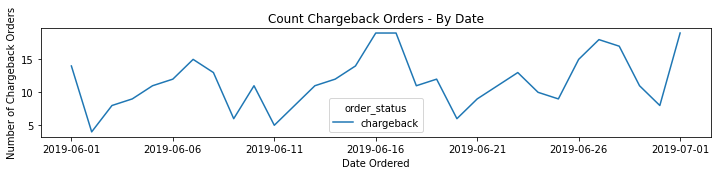

In [40]:
# create df with only chargeback orders
chargebacks_df = df[df['order_status'] == 'chargeback']

# group by order date and status, count orders
CHB_count_by_date = chargebacks_df.groupby(['order_date', 'order_status']).size().reset_index(name='count')

# reset index, pivot table on status to create columns chargeback counts
CHB_count_pivot = CHB_count_by_date.pivot(index='order_date', columns='order_status', values='count')

# create line plot
fig, ax = plt.subplots(figsize=(12, 2))
CHB_count_pivot.plot(ax=ax)

# add title and labels
plt.title('Count Chargeback Orders - By Date')
plt.xlabel('Date Ordered')
plt.ylabel('Number of Chargeback Orders')

# show the plot
plt.show()


In [41]:
print('max:',CHB_count_by_date.max())
print('min:',CHB_count_by_date.min())
print('\nmean', CHB_count_by_date.mean())
print('\nmedian', CHB_count_by_date.median())

max: order_date      2019-07-01
order_status    chargeback
count                   19
dtype: object
min: order_date      2019-06-01
order_status    chargeback
count                    4
dtype: object

mean count    11.612903
dtype: float64

median count    11.0
dtype: float64


**Notes: Time Series - Count of Events**
- count of chargeback events flucates between 4 and 19 per day
- mean count of chargeback event of 11.6
- median count of chargeback events of 11
- no room for interpretation of seasonality in this one month time series

##### Sum Price of Chargebacks  By Date

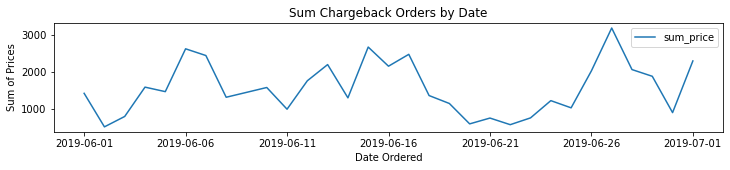

In [42]:
# group by date_ordered and sum the price of orders
sum_by_date = chargebacks_df.groupby('order_date')['price'].sum().reset_index(name='sum_price')

# set date_ordered as the index
sum_by_date.set_index('order_date', inplace=True)

# create a line plot
fig, ax = plt.subplots(figsize=(12, 2))
sum_by_date.plot(ax=ax)

# add title and labels
plt.title('Sum Chargeback Orders by Date')
plt.xlabel('Date Ordered')
plt.ylabel('Sum of Prices')

# show the plot
plt.show()


In [43]:
maximum_price_by_date = sum_by_date['sum_price'].max()
minimum_price_by_date = sum_by_date['sum_price'].min()
mean_price_by_date = sum_by_date['sum_price'].mean()
median_price_by_date = sum_by_date['sum_price'].median()

print('Maximum sum of price by date: ${:,.0f}'.format(maximum_price_by_date))
print('Minimum sum of price by date: ${:,.0f}'.format(minimum_price_by_date))
print('Mean sum of price by date: ${:,.0f}'.format(mean_price_by_date))
print('Median sum of price by date: ${:,.0f}'.format(median_price_by_date))

Maximum sum of price by date: $3,175
Minimum sum of price by date: $527
Mean sum of price by date: $1,569
Median sum of price by date: $1,451


In [44]:
# group by date and status, sum of price, count number of orders
agg_by_date = chargebacks_df.groupby(['order_date', 'order_status']).agg({'price': 'sum', 'order_id': 'count'}).reset_index()

# pivot table to set columns for price sum and oder count and reset index
time_price_count = agg_by_date.pivot(index='order_date', columns='order_status')

time_price_count 

,price,order_id
order_status,chargeback,chargeback
order_date,,
2019-06-01,1425.76,14
2019-06-02,526.90,4
2019-06-03,805.84,8
2019-06-04,1591.49,9
2019-06-05,1470.56,11
2019-06-06,2618.37,12
2019-06-07,2438.15,15
2019-06-08,1320.39,13


##### Analysis of Chargebacks by Day of Week 

###### Count of Chargeback Events by Day of Week 

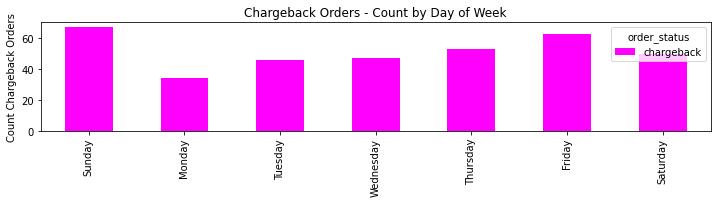

In [45]:
# copy 
chargebacks_df_datetime = chargebacks_df.copy()

# convert order_date to datetime type 
chargebacks_df_datetime['order_date'] = pd.to_datetime(chargebacks_df_datetime['order_date'])

# group by weekday of order date and status, count orders
CHB_count_by_weekday = chargebacks_df_datetime.groupby([chargebacks_df_datetime['order_date'].dt.weekday, 'order_status']).size().reset_index(name='count')

# reset index, pivot table on status to create columns for approved/chargeback counts
CHB_count_pivot_weekday = CHB_count_by_weekday.pivot(index='order_date', columns='order_status', values='count')

# create a bar chart, set x axis to days of week 
ax = CHB_count_pivot_weekday.plot(kind='bar', figsize=(12, 2), color='magenta').set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

# labels
plt.title('Chargeback Orders - Count by Day of Week')
plt.xlabel('')
plt.ylabel('Count Chargeback Orders')
plt.show()


In [46]:
CHB_count_pivot_weekday

order_status,chargeback
order_date,
0,67
1,34
2,46
3,47
4,53
5,63
6,50


###### Count of Events by Day of Week 

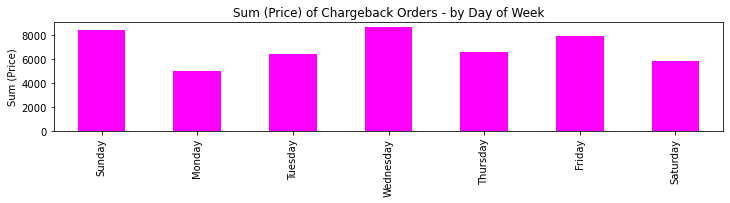

In [52]:
# group by weekday of order date and sum prices
sum_by_weekday = chargebacks_df_datetime.groupby(chargebacks_df_datetime['order_date'].dt.weekday)['price'].sum()


# create a magenta bar chart
fig, ax = plt.subplots(figsize=(12, 2))
sum_by_weekday.plot(kind='bar', color='magenta', ax=ax).set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

# labels
plt.title('Sum (Price) of Chargeback Orders - by Day of Week')
plt.xlabel('')
plt.ylabel('Sum (Price)')

# show the plot
plt.show()

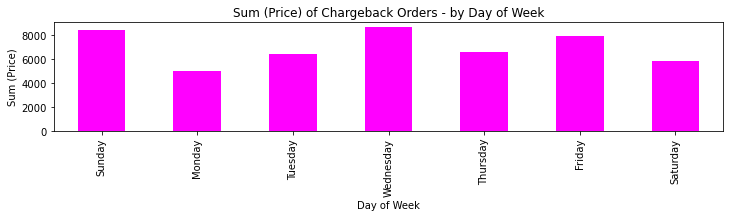

In [53]:
# Group by weekday of order date and sum prices
sum_by_weekday = chargebacks_df_datetime.groupby(chargebacks_df_datetime['order_date'].dt.weekday)['price'].sum()

# Create a magenta bar chart
fig, ax = plt.subplots(figsize=(12, 2))
sum_by_weekday.plot(kind='bar', color='magenta', ax=ax).set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

# Add labels to the chart
ax.set_title('Sum (Price) of Chargeback Orders - by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sum (Price)')

# Show the plot
plt.show()


In [54]:
sum_by_weekday.to_frame()

,price
order_date,
0,8380.77
1,4994.08
2,6413.32
3,8596.06
4,6567.37
5,7879.21
6,5806.31


In [62]:
price_summary = sum_by_weekday.describe().to_frame()
price_summary

,price
count,7.000000
mean,6948.160000
std,1365.534379
min,4994.080000
25%,6109.815000
50%,6567.370000
75%,8129.990000
max,8596.060000


In [57]:
maximum_price_by_weekday = sum_by_weekday.max()
minimum_price_by_weekday = sum_by_weekday.min()
mean_price_by_weekday = sum_by_weekday.mean()
median_price_by_weekday = sum_by_weekday.median()

print('Maximum sum of price by day of week: ${:,.0f}'.format(maximum_price_by_weekday))
print('Minimum sum of price by day of week: ${:,.0f}'.format(minimum_price_by_weekday))
print('Mean sum of price by day of week: ${:,.0f}'.format(mean_price_by_weekday))
print('Median sum of price by day of week: ${:,.0f}'.format(median_price_by_weekday))

Maximum sum of price by day of week: $8,596
Minimum sum of price by day of week: $4,994
Mean sum of price by day of week: $6,948
Median sum of price by day of week: $6,567


In [59]:
price_summary = sum_by_weekday.describe().to_frame()
price_summary

,price
count,7.000000
mean,6948.160000
std,1365.534379
min,4994.080000
25%,6109.815000
50%,6567.370000
75%,8129.990000
max,8596.060000


In [63]:
df.customer_account_age.nunique()

4053

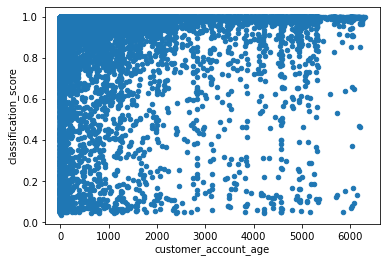

In [64]:
# explore relationship bet classifcation score and account age 
df.plot.scatter(x='customer_account_age', y='classification_score')
plt.title('Customer age and Classification Score')
plt.show()

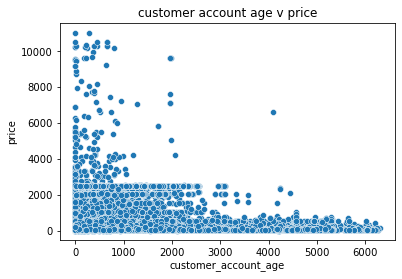

In [66]:
# create a scatterplot of price by customer_age_years
sns.scatterplot(data=df, x='customer_account_age', y='price')
plt.title('customer account age v price')
plt.show()


### NEXT STEPS
- learn more about the model 
- one hot encode and run correlations against score to identify which features are more closely correlated with score.
- create groupings for account_age and price and explore risk
